In [419]:
# Plots
# ==============================================================================

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")


Version skforecast: 0.14.0
Version scikit-learn: 1.6.0
Version pandas: 2.2.3
Version numpy: 1.26.4


In [420]:
data = pd.read_csv('h2_n2_data.csv', parse_dates=['timestamp'], index_col='timestamp')

In [421]:
data.head()

,HIC03062,HIC03044,AI03142,AI94011A,AI94011C,AI94011D,AI94011E,ground_truth_H2_N2_ratio
timestamp,,,,,,,,
2023-07-01 00:05:00,109.999168,0.784,14.011567,4.360608,91.031656,2.884754,0.098855,2.865227
2023-07-01 00:10:00,109.999309,0.784,14.049304,4.364124,91.315775,2.570169,0.097333,2.865396
2023-07-01 00:15:00,109.999423,0.784,14.069609,4.367528,91.597639,2.255717,0.095642,2.859329
2023-07-01 00:20:00,109.999519,0.784,14.091850,4.367595,91.597484,2.255740,0.095802,2.845370
2023-07-01 00:25:00,109.999596,0.784,14.124177,4.361142,91.578558,2.260947,0.095499,2.845211


In [422]:
data = data['2023-07-18 00:0:00':'2023-08-18 00:0:00']

In [355]:
data['AI94011A_1'] = data['AI94011A'].shift(1)
data['AI94011C_1'] = data['AI94011C'].shift(1)
data['AI94011D_1'] = data['AI94011D'].shift(1)
data['AI94011E_1'] = data['AI94011E'].shift(1)
data['HIC03062_1'] = data['HIC03062'].shift(1)
data['HIC03044_1'] = data['HIC03044'].shift(1)
data['AI03142_1'] = data['AI03142'].shift(1)

In [356]:
data['AI94011A_2'] = data['AI94011A'].shift(2)
data['AI94011C_2'] = data['AI94011C'].shift(2)
data['AI94011D_2'] = data['AI94011D'].shift(2)
data['AI94011E_2'] = data['AI94011E'].shift(2)
data['HIC03062_2'] = data['HIC03062'].shift(2)
data['HIC03044_2'] = data['HIC03044'].shift(2)
data['AI03142_2'] = data['AI03142'].shift(2)

In [423]:
data = data.asfreq('5min')

In [424]:
# Missing values
# ==============================================================================
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0017919139881285699


In [425]:
data = data.fillna(data.mean())

In [426]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


Train dates : 2023-07-18 00:00:00 --- 2023-08-14 12:40:00  (n=7929)
Test dates  : 2023-08-14 12:45:00 --- 2023-08-18 00:00:00  (n=1000)


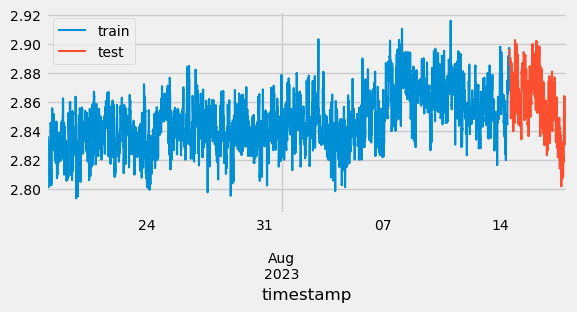

In [321]:
# Split data into train-test
# ==============================================================================
steps = 1000
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ground_truth_H2_N2_ratio'].plot(ax=ax, label='train')
data_test['ground_truth_H2_N2_ratio'].plot(ax=ax, label='test')
ax.legend();

In [322]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(alpha=0.001),
                 lags      = 6
             )
forecaster.fit(y=data_train['ground_truth_H2_N2_ratio'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2023-07-18 00:00:00'), Timestamp('2023-08-14 12:40:00')] 
Training index type: DatetimeIndex 
Training index frequency: 5min 
Regressor parameters: 
    {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-12-11 14:26:52 
Last fit date: 2024-12-11 14:26:52 
Skforecast version: 0.14.0 
Python version: 3.9.20 
Forecaster id: None

In [323]:
# Predictions
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2023-08-14 12:45:00    2.894907
2023-08-14 12:50:00    2.888566
2023-08-14 12:55:00    2.883311
2023-08-14 13:00:00    2.880596
2023-08-14 13:05:00    2.878406
Freq: 5min, Name: pred, dtype: float64

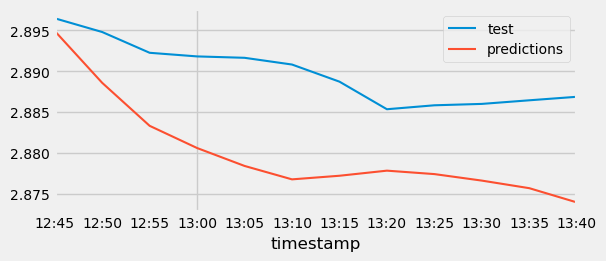

In [324]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
#data_train['ground_truth_H2_N2_ratio'].plot(ax=ax, label='train')
data_test.iloc[:12]['ground_truth_H2_N2_ratio'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [325]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.iloc[:12]['ground_truth_H2_N2_ratio'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.00010396537736097316


In [329]:
model_params = forecaster.regressor.get_params()
print(model_params)
# Example for feature importance
if hasattr(forecaster.regressor, "feature_importances_"):
    print(forecaster.regressor.feature_importances_)

{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [86]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 1000,
      initial_train_size = int(len(data_train) * 0.7),
      refit              = False,
      fixed_train_size   = False,

    )

# Candidate values for lags
lags_grid = [6]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['ground_truth_H2_N2_ratio'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.00034452015569259593


In [87]:
# Search results
# ==============================================================================
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 3, 'n_estimators': 100}",0.000345,3,100
1,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 3, 'n_estimators': 50}",0.000345,3,50
2,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 5, 'n_estimators': 50}",0.000663,5,50
3,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 5, 'n_estimators': 100}",0.000666,5,100


In [427]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
#regressor = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=123)
regressor = Ridge(alpha=0.0001)
# regressor=xgb.XGBRegressor(
#         objective='reg:squarederror',  # Objective function
#         n_estimators=100,  # Number of trees
#         max_depth=5,  # Maximum depth of trees
#         learning_rate=0.01  # Learning rate
#         )
forecaster = ForecasterDirect(
                 regressor = regressor,
                 steps = 12,
                 lags = 6
             )
forecaster.fit(y=data_train['ground_truth_H2_N2_ratio'])
               # exog=data_train[['HIC03062_1','HIC03044_1','AI03142_1'
               #                  ,'AI94011A_1','AI94011C_1','AI94011D_1','AI94011E_1'
               #                  ,'HIC03062_2','HIC03044_2','AI03142_2'
               #                  ,'AI94011A_2','AI94011C_2','AI94011D_2','AI94011E_2']])

In [428]:
#Backtesting

In [429]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12, 
         initial_train_size = 10 * 12,
         fixed_train_size   = True,
         refit              = True,
)
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['ground_truth_H2_N2_ratio'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = False
                                )
metric

/Users/vayu/anaconda3/envs/opera/lib/python3.9/site-packages/skforecast/model_selection/_validation.py:191: LongTrainingWarning: The forecaster will be fit 8820 times (735 folds * 12 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [00:30<00:00, 24.09it/s]


,mean_squared_error
0,0.000222


In [430]:
predictions_backtest

,pred
2023-07-18 10:00:00,2.824656
2023-07-18 10:05:00,2.821439
2023-07-18 10:10:00,2.818634
2023-07-18 10:15:00,2.815096
2023-07-18 10:20:00,2.811174
...,...
2023-08-17 23:40:00,2.836989
2023-08-17 23:45:00,2.836949
2023-08-17 23:50:00,2.837161
2023-08-17 23:55:00,2.837300


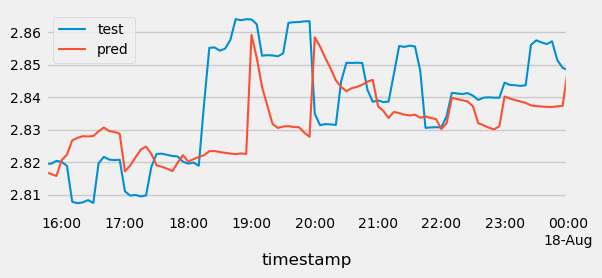

In [431]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
#data_train['ground_truth_H2_N2_ratio'].plot(ax=ax, label='train')
data.iloc[-100:]['ground_truth_H2_N2_ratio'].plot(ax=ax, label='test')
predictions_backtest.iloc[-100:].plot(ax=ax, label='predictions')
ax.legend();

In [432]:
actual_vals = data.loc[predictions_backtest.index, 'ground_truth_H2_N2_ratio'].to_numpy()

In [433]:
predicted_vals = predictions_backtest.to_numpy()

In [434]:
predictions_backtest

,pred
2023-07-18 10:00:00,2.824656
2023-07-18 10:05:00,2.821439
2023-07-18 10:10:00,2.818634
2023-07-18 10:15:00,2.815096
2023-07-18 10:20:00,2.811174
...,...
2023-08-17 23:40:00,2.836989
2023-08-17 23:45:00,2.836949
2023-08-17 23:50:00,2.837161
2023-08-17 23:55:00,2.837300


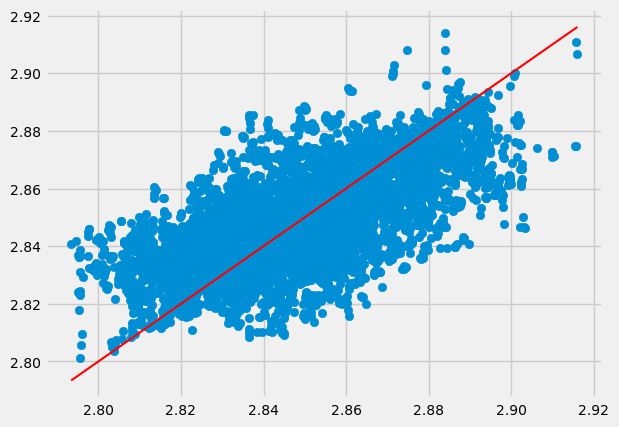

In [435]:
plt.scatter(actual_vals, predicted_vals)
plt.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], color='red')

In [436]:
from sklearn.metrics import r2_score
r2 = r2_score(actual_vals, predicted_vals)
print("R-squared:", r2)

R-squared: 0.42997875846171774
